In [1]:
import numpy as np
import h5py
import netCDF4 as nc
import matplotlib.pyplot as plt
import datetime
import empirical_variogram as eva
import glob
import pandas as pd

In [2]:
import os
import numpy as np
import datetime as dt
from netCDF4 import Dataset

def write_netcdf(fname,dtime,variogram_data,bins,flag,odir):
    
    filename = odir+fname      
    if os.path.isfile(filename): os.remove(filename)
    
    nbin = len(bins)
    
    ncfile = Dataset(filename,'w',format='NETCDF4')
    
    # Dimensions
    ncfile.createDimension('time',None)
    ncfile.createDimension('distance',nbin)
    
    #Dimension Variables
    utime                      = np.array(dtime.astype(np.int64)/1e9,dtype=int)
    time                        = ncfile.createVariable('time', 'i4', ('time',))
    time[:]                     = utime
    time.long_name      = 'time'
    time.units                = 'seconds since 1970-01-01 00:00:00 UTC'
    time.comment        = 'LT = UTC+8'
    
    distance            = ncfile.createVariable('distance', 'f4', ('distance',)) 
    distance[:]         = bins
    distance.long_name  = 'mid points of distance bins'
    distance.units      = 'm'
    
    variogram           = ncfile.createVariable('variogram','f4',('time','distance',),
                                                 fill_value='nan',zlib=True,
                                                 complevel=1)
    variogram[:]        = variogram_data
    variogram.long_name = 'empirical variogram of near-surface air temperature'
    variogram.units     = 'K2'
    
    cp_flag             = ncfile.createVariable('cp_flag', 'f4', ('time',)) 
    cp_flag[:]          = flag
    cp_flag.long_name   = 'cold pool flag'
    cp_flag.units       = '1'
    cp_flag.comment     = '0 = no cp, 1 = cp start, 2 = cp'
        
    # Global attributes
    ncfile.Processing_date   = dt.datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S UTC')    
    ncfile.Author            = 'Nicholas Falk (nick.falk@colostate.edu)'     

 

    ncfile.close()
    return  

In [3]:
#
'''
main_dir = './SF16/'
ncfile_name = 'CS-TropOce-1000_variogram-data_v02.nc'
startt = datetime.datetime(2019,9,28,22,0)
num_times = 49
sim_output_freq = '15min'
cp_onset = datetime.datetime(2019,9,29,5,30)
specified_times = [24,28,32,36,40,44,48]
'''
#

#

main_dir = './HRT12/'
ncfile_name = 'CS-TropOce-100_variogram-data_v02.nc'
startt = datetime.datetime(2019,9,29,0,0)
num_times = 121
sim_output_freq = '5min'
cp_onset = datetime.datetime(2019,9,29,5,30)
specified_times = np.array([16,20,24,28,32,36,40])*3

#

In [4]:
network_file = h5py.File(main_dir+"network_info.h5", 'r')
network_delta_x = np.array(network_file['network_delta_x'])
network_delta_y = np.array(network_file['network_delta_y'])
network_file.close()

In [5]:
network_Ts_files = np.sort(glob.glob(main_dir+'network_Ts/*')).astype(str)
network_Ts = np.zeros((len(network_Ts_files),len(network_delta_x)))
network_Ts[:] = np.NaN
for i in range(len(network_Ts_files)):
    network_T_file =  h5py.File(network_Ts_files[i], 'r')
    network_Ts[i,:] = np.array(network_T_file['network_Ts'])

In [6]:
coordinates = pd.DataFrame(data={'X': network_delta_x, 'Y': network_delta_y})
pairs = eva.pair_stations(coordinates)

In [7]:
temp_data = pd.DataFrame(network_Ts)

In [8]:
all_variograms = np.zeros((len(network_Ts_files),30))
all_gradiograms = np.zeros((len(network_Ts_files),30))
all_variograms[:] = np.NaN
all_gradiograms[:] = np.NaN
for i in range(len(network_Ts_files)):
    all_variograms[i,:] = eva.calc_variogram(temp_data.loc[i],pairs)
    all_gradiograms[i,:] = eva.calc_variogram(temp_data.loc[i],pairs,func=eva.gradiogram)
for_bins = eva.calc_variogram(temp_data.loc[0],pairs)
bins = np.array(for_bins.index)

In [9]:
all_times = pd.date_range(startt, periods=num_times, freq=sim_output_freq)
cp_flag = np.zeros(np.shape(all_times))
cp_flag[all_times<cp_onset] = 0
cp_flag[all_times==cp_onset] = 1
cp_flag[all_times>cp_onset] = 2

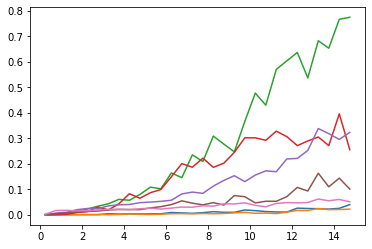

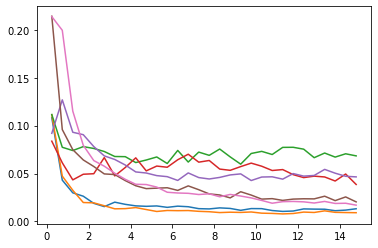

DatetimeIndex(['2019-09-29 04:00:00', '2019-09-29 05:00:00',
               '2019-09-29 06:00:00', '2019-09-29 07:00:00',
               '2019-09-29 08:00:00', '2019-09-29 09:00:00',
               '2019-09-29 10:00:00'],
              dtype='datetime64[ns]', freq=None)


In [10]:
# quick plots for sanity check
plt.plot(bins/1000,np.transpose(all_variograms[specified_times,:]))
plt.show()
plt.plot(bins/1000,np.transpose(all_gradiograms[specified_times,:]))
plt.show()
print(all_times[specified_times])

In [11]:
write_netcdf(ncfile_name,all_times,all_variograms,bins,cp_flag,odir='./')